In [1]:
import warnings
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import requests
from IPython.core.display import HTML

import lime
import lime.lime_tabular
import shap

from pipelines.functions import see_results, evaluate_metrics
from ml_injection_pipeline import prediction_pipeline
from tools.feed import data_info
from utils.config import DATASET_PATH, MODELS_PATH, MODEL_DATA_PATH

warnings.filterwarnings("ignore")

# Challenge 1: Regression model

![model_diagram](static/img/model_schema_xtreme.drawio.png)

<br />

The common and exclusive samples are based on the median price of the diamonds.

In [2]:
# DATA FEED
df = pd.read_csv(DATASET_PATH)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
# EXPLORATORY DATA ANALYSIS
data_info(df, sorted=True)

,index,columna,NaNs,pct_nan,dtype,count,count_unique,pct_unique
0,6,price,0,0.0,int64,5000,3179,63.58
1,5,table,0,0.0,float64,5000,78,1.56
2,4,depth,0,0.0,float64,5000,121,2.42
3,0,carat,0,0.0,float64,5000,202,4.04
4,9,z,0,0.0,float64,5000,304,6.08
5,8,y,0,0.0,float64,5000,471,9.42
6,7,x,0,0.0,float64,5000,474,9.48
7,1,cut,0,0.0,object,5000,5,0.10
8,2,color,0,0.0,object,5000,7,0.14
9,3,clarity,0,0.0,object,5000,8,0.16


In [4]:
# EXPLORATORY DATA ANALYSIS
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


In [5]:
# REMOVE OUTLIERS
outlier_sample = df[(df.price <= 0)]
df = df[(df.price > 0)].reset_index(drop=True)
display(outlier_sample)

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


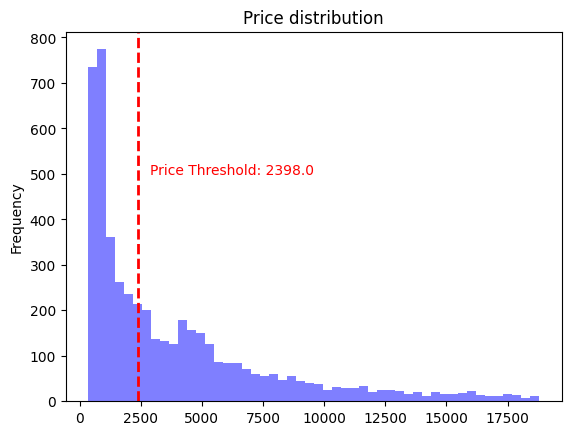

In [6]:
# Plot the histogram
price_threshold = df.price.median()
df.price.plot.hist(bins=50, alpha=0.5, color='b', title='Price distribution')

# Add a vertical line at the median price value
plt.axvline(price_threshold, color='r', linestyle='--', linewidth=2)

# Add text mentioning the median value
plt.text(price_threshold +500, 500, f"Price Threshold: {price_threshold}", color='r')

# Show the plot
plt.show()

In [7]:
# PRE CATEGORIZATION PROCESS USSING MEDIAN PRICE
exclusive_sample = df.loc[np.where(df.price >= price_threshold)[0], :]
common_sample = df.loc[np.where(df.price < price_threshold)[0], :]

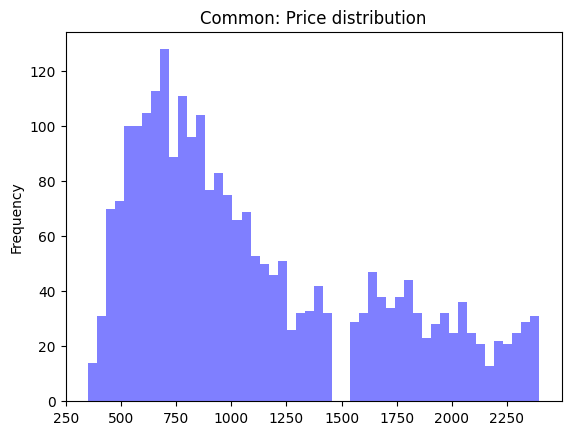

In [8]:
common_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Common: Price distribution');

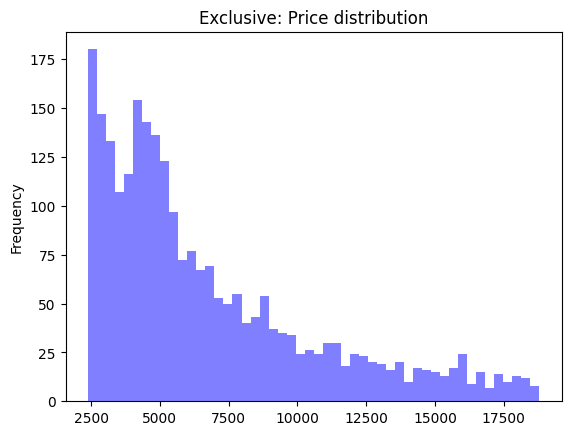

In [9]:
exclusive_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Exclusive: Price distribution');

## 1st model: Logistic Regression

In [10]:
X_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_X_test.csv'))
y_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_y_cat_test.csv'))

with open(os.path.join(MODELS_PATH, 'log_reg.pkl'), 'rb') as f:
    log_reg = pickle.load(f)

display(X_test.head())
print('shape:', X_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,2.575858,0.901561,-0.200897,2.084398,2.033043,2.201634,-0.177552,-0.315312,-0.811478,1.681494,...,-0.341073,4.377398,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
1,0.681525,-2.022046,1.558796,0.895011,0.952899,0.636074,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
2,-0.467846,-1.186730,-0.640820,-0.258605,-0.235260,-0.378641,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,-0.443040,1.848223,-0.275701,-0.321989
3,-1.042532,-0.769072,-0.200897,-1.233366,-1.216391,-1.291884,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989
4,-1.042532,0.205464,0.678949,-1.304908,-1.297402,-1.277388,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989


shape: (998, 26)


Train ROC AUC Score: 0.9989
Validation set confusion matrix


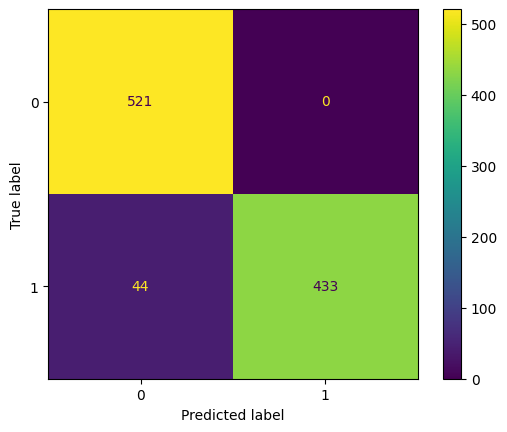

In [11]:
log_reg_train = log_reg.predict_proba(X_test)[:, 1]

# CATEGORIZATION MODEL EVALUATION
roc_auc_train = roc_auc_score(y_true=y_test, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Confusion Matrix
threshold = 0.92
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_train > threshold)
print("Validation set confusion matrix")
ConfusionMatrixDisplay(test_confusion_matrix).plot();

## 2nd model: LightGBM Common sample

Diamond with price under the median price.


In [12]:
Xc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_val.csv'))
yc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_val.csv'))
Xc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_test.csv'))
yc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_common.pkl'), 'rb') as f:
    lgbm_common = pickle.load(f)
    
display(Xc_val.head())
print('validation set shape:', Xc_val.shape)
print('test set shape:', Xc_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.933582,0.465398,-0.968536,-1.033948,-1.013368,-0.930846,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,-0.542607,2.963834,-0.379262
1,0.781185,-0.245340,-0.968536,0.929906,0.987682,0.902642,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,1.842953,-0.337401,-0.379262
2,0.855740,-1.035049,-0.015001,1.138827,1.008746,0.834735,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,3.030458,-0.462722,-0.542607,-0.337401,-0.379262
3,-0.784472,0.860253,0.461767,-0.866811,-0.971241,-0.761078,-0.133597,-0.31675,-0.949185,1.875057,...,3.364668,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,1.842953,-0.337401,-0.379262
4,-0.113476,0.465398,-0.968536,-0.031129,-0.065502,0.053805,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,-0.542607,-0.337401,2.636701


validation set shape: (498, 26)
test set shape: (5, 26)


R2 Score: 0.95 with Variance score: 0.95
MAE Score: 73.71
Max error: 1587.44
(Total price of sample, Predicted total price, Difference)
564460 563993 -467


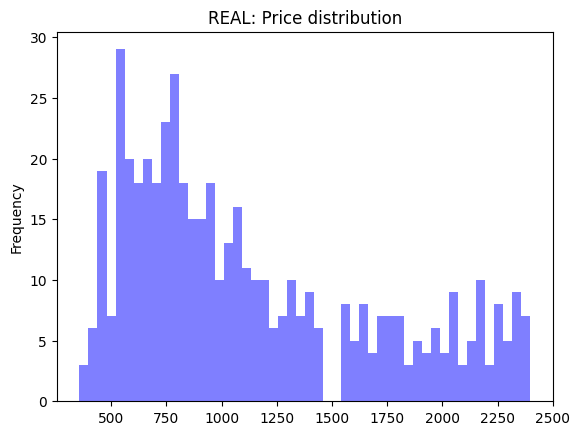

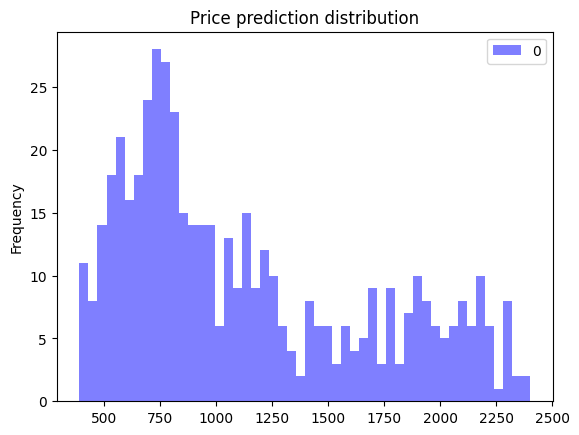

In [13]:
# MODEL PREDICTION AND EVALUATION
lgbm_pred_val = lgbm_common.predict(Xc_val)
lgbm_pred_test = lgbm_common.predict(Xc_test)

evaluate_metrics(yc_val, lgbm_pred_val)
see_results(yc_val, lgbm_pred_val)

R2 Score: 0.99 with Variance score: 0.99
MAE Score: 47.07
Max error: 120.75
(Total price of sample, Predicted total price, Difference)
5548 5412 -136


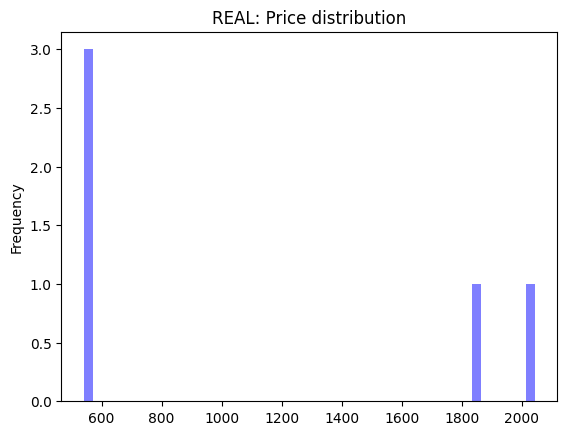

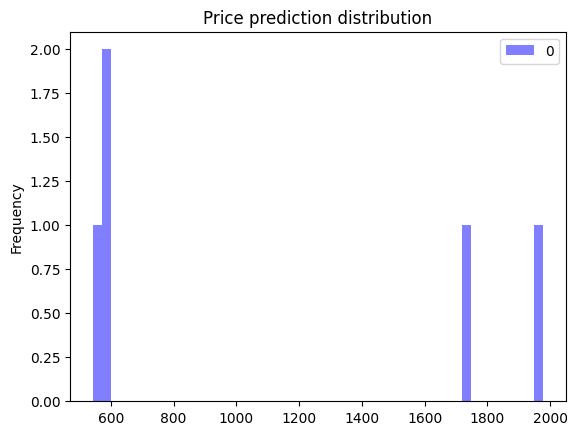

In [14]:
evaluate_metrics(yc_test, lgbm_pred_test)
see_results(yc_test, lgbm_pred_test)

## 3rd model: LightGBM Exclusive sample


In [15]:
Xe_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_val.csv'))
ye_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_val.csv'))
Xe_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_test.csv'))
ye_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_exclusive.pkl'), 'rb') as f:
    lgbm_exclusive = pickle.load(f)
    
display(Xe_val.head())
print('validation set shape:', Xe_val.shape)
print('test set shape:', Xe_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.331278,0.101041,-0.756347,-0.251117,-0.309375,-0.260185,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,1.820586,-0.392062,-0.5547,-0.195193,-0.257853
1,-0.674105,-0.084928,-1.180629,-0.532225,-0.594443,-0.578371,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,2.550620,-0.5547,-0.195193,-0.257853
2,0.222518,-0.146917,-0.332066,0.325154,0.417547,0.330733,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,-0.392062,-0.5547,-0.195193,3.878185
3,-0.304907,-1.262730,0.516497,-0.012176,-0.081321,-0.351095,-0.22272,-0.324983,-0.702313,1.558625,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,2.550620,-0.5547,-0.195193,-0.257853
4,-0.410392,0.658947,0.516497,-0.433837,-0.494669,-0.305640,-0.22272,-0.324983,-0.702313,1.558625,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,1.820586,-0.392062,-0.5547,-0.195193,-0.257853


validation set shape: (497, 26)
test set shape: (5, 26)


R2 Score: 0.95 with Variance score: 0.95
MAE Score: 567.96
Max error: 7750.09
(Total price of sample, Predicted total price, Difference)
3546716 3515104 -31612


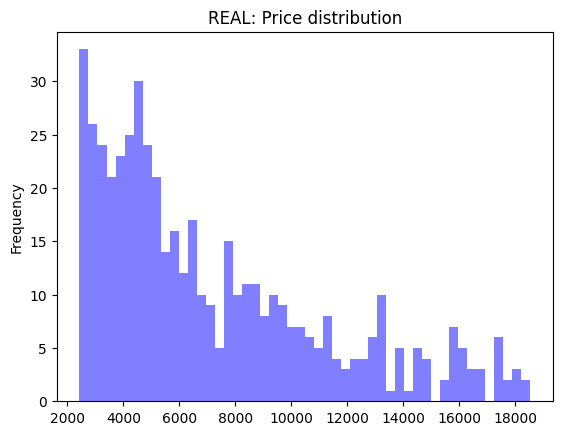

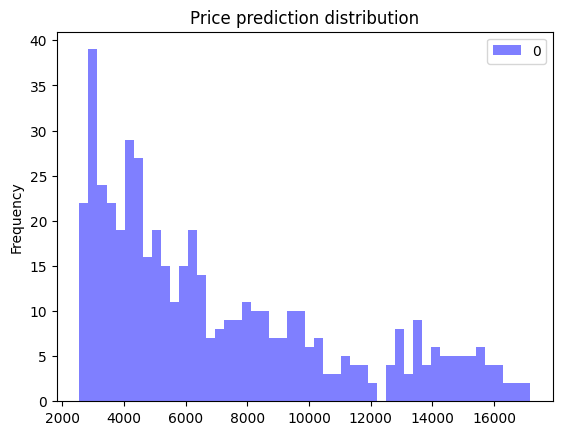

In [16]:
# MODEL PREDICTION
lgbm_pred_val = lgbm_exclusive.predict(Xe_val)
lgbm_pred_test = lgbm_exclusive.predict(Xe_test)

evaluate_metrics(ye_val, lgbm_pred_val)
see_results(ye_val, lgbm_pred_val)

R2 Score: 0.24 with Variance score: 0.32
MAE Score: 506.75
Max error: 1307.72
(Total price of sample, Predicted total price, Difference)
22270 21193 -1077


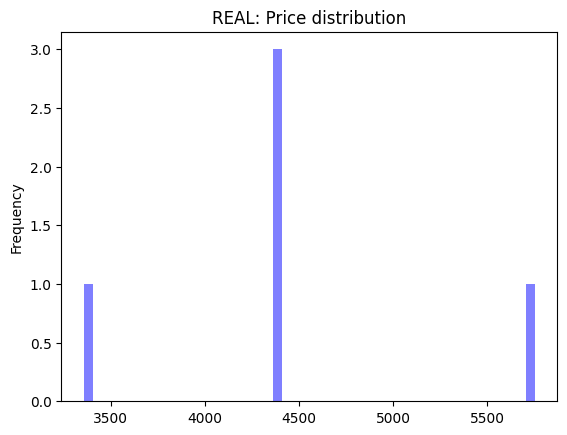

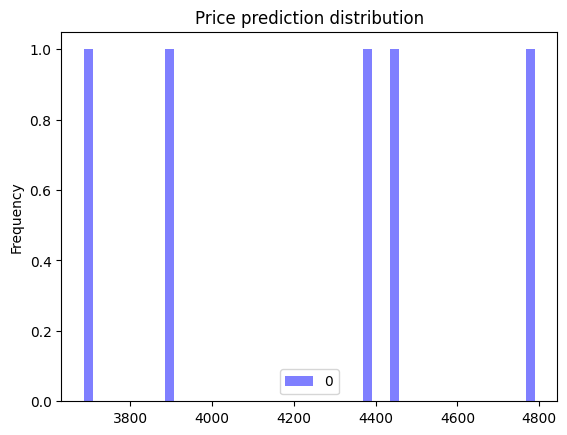

In [17]:
evaluate_metrics(ye_test, lgbm_pred_test)
see_results(ye_test, lgbm_pred_test)

# PREDICTION INTERPRETATIONS

In [18]:
# SELECT RANDOM SAMPLES
sample = df.sample(3)
sample_X = sample.drop(columns='price')
sample_y = sample.price
display(sample_X)
print(sample_y)

,carat,cut,color,clarity,depth,table,x,y,z
4914,0.55,Premium,G,SI1,60.1,61.0,5.32,5.29,3.19
1056,0.35,Ideal,D,VS2,61.8,55.0,4.53,4.56,2.81
3834,2.26,Premium,H,SI1,60.3,58.0,8.56,8.51,5.15


4914     1377
1056      829
3834    18426
Name: price, dtype: int64


In [19]:
# CREATE THE INPUTS
sample_0 = sample_X.iloc[0]
sample_1 = sample_X.iloc[1]
sample_2 = sample_X.iloc[2]

# OBTAIN THE REAL PRICE VALUE
real_0 = sample_y.iloc[0]
real_1 = sample_y.iloc[1]
real_2 = sample_y.iloc[2]

# PREDICT THE PRICE
pred_0 = prediction_pipeline(sample_0.to_dict())
pred_1 = prediction_pipeline(sample_1.to_dict())
pred_2 = prediction_pipeline(sample_2.to_dict())

In [20]:
# PRINT THE RESULTS
print("real price:", real_0)
print("prediction:", pred_0)

real price: 1377
prediction: 1239.3


In [21]:
# PRINT THE RESULTS
print("real price:", real_1)
print("prediction:", pred_1)

real price: 829
prediction: 1351.2


In [22]:
# PRINT THE RESULTS
print("real price:", real_2)
print("prediction:", pred_2)

real price: 18426
prediction: 17252.4


# Challenge 2: Automated pipeline

The **training pipeline** is design as a Python script that when executed, it will read the current `diamond.csv` file stored in the `.dataset/diamond` folder.
Inside the script, there is a **feature engineering** pipeline called `workflow_1` and three other pipelines for the models: `pipeline_1`, `pipeline_2`, and `pipeline_3`.

The intention is to automate the process of training and updating the models with the new data.
One possible way of making the updates automatic is to create a **Apache-Airflow** DAG for scheduling the pipeline execution.

At the moment the pipeline is executed during the container start, but if you want to run it manually these are the necessary steps to follow:

## Pipeline Local Execution

1. Create a virtual environment and install the requirements:

Linux:

```bash
$ python3 -m venv .venv
$ source .venv/bin/activate
$ pip install -r requirements.txt
```

Windows:

```bash
python -m venv .venv
.venv\Scripts\activate
pip install -r requirements.txt
```

<br />

2. Run the pipeline:
```bash
$ python ml_train_pipeline.py
```

After running the script, the models will be saved in the `.models` folder and the data in the `.models/data` folder.


# Challenge 3: Rest API

In [23]:
response = requests.get('http://localhost:8000/')
HTML(response.text)

In [ ]:
exit()

# Challenge 4: Architecture explanation

The next step is exposing the model to other businesses, but this calls for an upgrade in the training and serving infrastructure. Using your favorite cloud provider, either AWS, GCP, or Azure, design cloud-based training and serving pipelines. You should not implement the solution, but you should provide a detailed explanation of the architecture and the services you would use, motivating your choices.

# Cementery

In [ ]:
# LIME
# PREDICTIONS EXPLANATION FOR COMMON MODEL
# https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular

X_train = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_train.csv'))

explainer = lime.lime_tabular.LimeTabularExplainer(
X_train.to_numpy(), feature_names=X_train.columns,
verbose=True, mode='regression')

exp = explainer.explain_instance(np.array([sample_0.values]), prediction_pipeline)
exp.show_in_notebook(show_table=True)
exp.as_list()


TypeError: '<' not supported between instances of 'float' and 'str'

: 

![lime output](static/img/lime_output.png)

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(prediction_pipeline)

print("real price:", real_0)
print("prediction:", pred_0)

shap_values = explainer(sample_0.values)
shap.plots.waterfall(shap_values[0])

ValueError: masker cannot be None.

real price: [17317]
prediction: [14864.2]


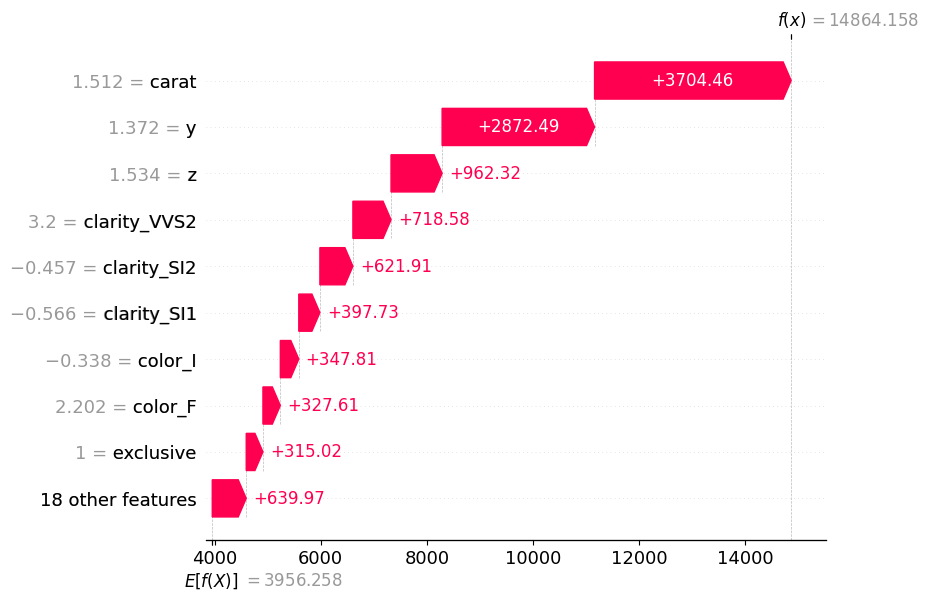

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(lgbm)
print("real price:", y_test.iloc[predict_index].values)
print("prediction:", lgbm.predict(X_test.iloc[predict_index]).round(1))
shap_values = explainer(X_test.iloc[predict_index].to_frame().T)
shap.plots.waterfall(shap_values[0])